# Estimation: From historical data to the future dynamics of returns

> "It is a capital mistake to theorize before one has data"

---

**🎯 Learning Objectives**

1. Our objective here is to understand when and how past data is informative about the future behavior of returns

2. Factor model and it's parameters are an useful lens because it allow us to separate the pieces that the data is useful from the pieces that the data is not

3. We will look at $\beta$'s, Variances, factor premia, and alphas

4. This class might feel as "stats" class, but it is at the core of quant investing

5. What information is in the data?


---






## Libraries and Auxiliary Functions

In [2]:
## Every time we start a new colab we need to install and import WRDS (if we are goign to use it)
## The way it works is that you click install and then an error is returned and you click "RESTART"
## Once you do that you can import it (i.e. run the next cell)
#%pip install wrds

In [3]:
## for this to work you first need to install it
#import wrds

In [4]:
# load libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_datareader.data as DataReader

# define functions
def get_daily_wrds(conn,tickers=None):

    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs

    query = f"""
        SELECT permno, date, ret, retx, prc
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date,permno
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    daily_returns=daily_returns[tickers]

    return daily_returns


def get_factors(factors='CAPM'):
    if factors=='CAPM':
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF']]
    elif factors=='FF3':
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':
        fama_french = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
    else:
        fama_french = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
        daily_data.index = pd.to_datetime(daily_data.index)
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
        fama_french = DataReader.DataReader("F-F_Momentum_Factor_daily", "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')

    return df_factor/100

## Factor Model recap

We have been working with a single asset, since factor model

Realized returns:

$$r=rf+\alpha + b(f-rf)+\epsilon$$

Expected  returns

$$E[r]=rf+\alpha + b*E[f]$$


Expected excess returns

$$E[r^{e}]=\alpha + b*E[f]$$

Variance:


$$Var(r)=b^2Var(f-rf)+Var(\epsilon)$$


To know the expected returns of your investment you need
1. The risk-free rate
2. The beta
3. The factor risk-premia
4. The asset specific alpha

To know the risk/variance of your investment you need

5. The factor variance
6. The asset specific variance




## What is the estimation problem that we need to solve?

- Do you want to know how this stock behaved in the past? ❌

- Do we want to know how it behaved in the recent past?❌

- So why should we care about historical data?




**It is about the future, Watson ✅**

- We need to estimate these moments for our investment period, say next minute, day, month or year

- Some of those we observe directly in financial markets like the risk-free rate--financial markets tell you exactly how much your will earn going forward--just look at government bonds

- Others we need to use  data to form our views

- None of this specific to factor models. But factor models are helpful in stripping the estimation problem in different pieces


- We discuss below one-by-one


## Betas (Factor Loadings)


Factors models are all about the time-series co-movement between assets and some common factors. For now we are focused on single factors models, but we will soon be thinking about multiple-factors at the same time.

We will focus on factors that can be expressed in excess returns, like the returns on the market portfolio. Practicioners often use characteristics as direct proxys for betas--we will see that later. This is useful when we have many factors...but does not work to the most important factor of all--the market factor.

Fundamentally any risk-factor can be represented in terms of a return of a specific portfolio.

The beta that we are interested is the forward-looking degree of co-movement between the asset and the factor

Specifically it is

$$\beta_t=\frac{Cov_t(r_{t+1}^{e},f_{t+1})}{var_t(f_{t+1})}$$


- What this notation means?
- It is asking to what extent the asset returns are above it's expected values when the factor is above it's expected value
- It normalizes everything by the variance of the factor
- So a beta of 1 means that the asset is EXPECTED to move 1 for 1 with the factor
- But of course it can have some additional indio risk on top
- The subscripts in the covariance and variance means that it is these moments from the perspective of someone that has all the information up to  date $t$
- That is, you don't know the particular realization of the variables--you do not have a crystal ball




### Our Data

- Pick your favorite stock, construct excess returns
- Use returns on the market as a factor
-

In [5]:
## uncomment to use WRDS to get data
######################################
# conn = wrds.Connection()
# tickers=['GE']
# df = get_daily_wrds(conn,tickers)
# df.to_csv('../../assets/data/FactorModelsEstimation_data1.csv')
#######################################
df=pd.read_csv('https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/FactorModelsEstimation_data1.csv')
df.date=pd.to_datetime(df.date)
df.set_index('date',inplace=True)



df_factor = get_factors()
df, df_factor = df.dropna().align(df_factor.dropna(), join='inner', axis=0)
tickers=['GE']
df_re=df[tickers].sub(df_factor['RF'],axis=0)
# why not the simpler code below? Which one is more robust?
#df_re=df[tickers]-df_factor['RF']
display(df_re.head())
display(df_re.tail())

/tmp/ipython-input-1066857734.py:38: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start="1921-01-01")


,GE
1926-07-01,-0.000090
1926-07-02,-0.000090
1926-07-06,0.007220
1926-07-07,-0.000090
1926-07-08,0.004264


,GE
2024-12-24,0.014444
2024-12-26,0.003679
2024-12-27,-0.010568
2024-12-30,-0.011812
2024-12-31,-0.007963


### How do we estimate betas?

We run a regression!

- if we include a constant (as we should), the the regression slope of the asset on the factor is our beta

$$\beta=\frac{Cov(r,f)}{Var(f)}$$

- We typically do not use the whole sample when using individual stocks--stocks behavior change. So we want the most up to date behavior
- but cannot be too short otherwise you cannot say anything as estimation uncertainty will be very high!
- Optimal look-back window will trade-off these forces and might vary according the asset/strategy
- Academic literature likes to use between 1 year to 2 years if using daily data for stocks. Longer if betas of systematic trading strategies

👉 when working with illiquid stocks daily data might be problematic and weekly or monthly might be more advisable, but the sample period will have to be increased. For example, for monthly people use 5 years)

We will focus on simple regressions, and briefly discuss alternatives

⚡ ⏰ Question: G1 ⚡
Complete the code below and abe prepared to answer the questions

In [6]:
#instead of using the smf api that uses formulas we will use the sm api that uses matrices
import statsmodels.api as sm
X = sm.add_constant(df_factor['Mkt-RF'])  # Adds a constant term to the predictor
y = df_re['GE']
model = sm.OLS(y, X).fit()
display(model.summary())

from scipy.stats import norm # this is to get the normal distribution

#1. How well is estimated? Recover the standard error
print(model.__)
#2. Given this, how well it is estimated?
#3. Based on this how confident we are that the beta is more  than 1? ( this is qualitative)
#4. How much uncertainty do we have about it? what is the 95% confidence interval?
print([model.__['Mkt-RF'] +1.96*model.__['Mkt-RF'],model.__['Mkt-RF'] -1.96*model.__['Mkt-RF']])
#5. How do I adjust the t-statistic to test if beta is greater than 1 (or any other number)?
tstat=(model.__['Mkt-RF'] -__)/model.__['Mkt-RF']
print(tstat)
#6. Given this t-statistic what is the probability that beta is greater than 1? And less than 1?
probmorethan1=__-norm.__(tstat)
print(probmorethan1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GE   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                 3.119e+04
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:48:54   Log-Likelihood:                 77611.
No. Observations:               25898   AIC:                        -1.552e+05
Df Residuals:                   25896   BIC:                        -1.552e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.159e-05   7.51e-05      0.287      0.774      -0.000       0.000
Mkt-RF         1.2313      0.007    176.612      0.000       1.218       1.245
==============================================================================
Omnibus:                     5524.438   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136801.661
Skew:                           0.427   Prob(JB):                         0.00
Kurtosis:                      14.227   Cond. No.                         92.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

AttributeError: 'OLSResults' object has no attribute '__'

### Is this too Good to be true?

- But is beta really constant?
- Should we be using such a long sample?
- Lets look at at 2 year periods
- To do this efficiently we will use the groupby method
- We will first create a function that does the regression and returns the beta

### Betas over time

- Almost always above 1, but all over the place

- are the betas really changing like that?



<Axes: >

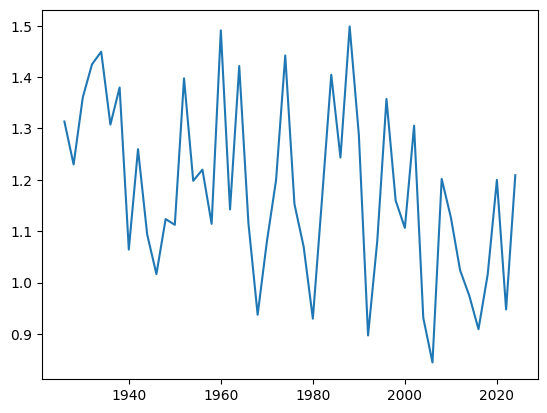

In [7]:
# the Betas for each 2 year period

# We start by putting the factor and the excess return series together in a DataFrame called `df_m`.
df_m=df_factor
df_m['re']=df_re['GE']
# now we define a function that does the regression and returns the beta
def regression_beta(df):
    """
    Function to estimate the beta of a stock using OLS regression.
    """
    X = df['Mkt-RF']
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['re']
    model = sm.OLS(y, X).fit(dropna=True)
    return model.params['Mkt-RF']
######################################
df_m.groupby((df.index.year // 2) * 2).apply(regression_beta).plot()


#### 🐍 Note: function definition

We can build our own function as follows

```
def name_of_function(input1,input2,...,inputA='defaultA',..,inputZ='defaultZ'):
    Write all you want the function to do
    LINE
    LINE
    as long it has 4 white spaces it will belong to the function
    return Whaterver_you_want_to_return_if_anything
```

In [ ]:
def regression_beta(df):
    """
    Function to estimate the beta of a stock using OLS regression.
    """
    X = df['Mkt-RF']
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['re']
    model = sm.OLS(y, X).fit(dropna=True)
    return model.params['Mkt-RF']


regression_beta(df_m)

#### 🐍 Note: Groupby

this is the first time we see the groupby method in pandas

 - Groupby is a method in pandas that allows you to group data based on some criteria (e.g., a column or a function applied to the index).
 - Once grouped, you can apply aggregation or transformation functions (e.g., mean, sum, or custom functions) to each group independently.
 - The grouping can be based on labels, index levels, or a custom function applied to the index or columns.
 - After applying the function, the results are combined into a new DataFrame or Series.

Here the line that will estimate the rolling betas for us

```
df.groupby((df.index.year // 2) * 2).apply(regression_beta).plot()
```

 now there is a lot going on in this line, so let's break it down step by step:
 1. `df.groupby((df.index.year // 2) * 2)`: The data is grouped by two-year periods.
    - `df.index.year` extracts the year from the index (assumed to be a datetime index).
    - `df.index.year // 2` divides the year by 2 (integer division) to group years into two-year blocks.
    - `* 2` converts the two-year blocks back to the starting year of the block (e.g., 2020 and 2021 are grouped as 2020).
 2. `.apply(regression_beta)`: For each two-year group, the regression_beta function is applied which must return the beta for the sample period
 3. `.plot()`: The extracted beta values for each two-year period are plotted to visualize how the beta changes over time.

> how do I change to have 1 year periods? and 6 month periods?

In [ ]:
# the group
_temp=df_m.copy()
_temp['group']=(df.index.year // 2) * 2
display(_temp['2001-12-26':'2002-1-4'])
display(_temp['2002-12-26':'2003-1-4'])

### Uncertainty

- We are looking at point **estimates**
- The variation in the data might be just sample uncertainty
- We will now construct standard errors and confidence intervals to gauge whether this variation is real or a mirage

<Axes: >

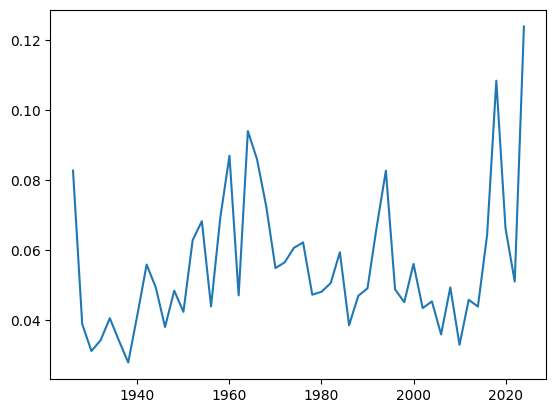

In [26]:
df_m.groupby((df_m.index.year // 2) * 2).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().bse['Mkt-RF']).plot()

#How do the standard errors compare with the full sample one?

# is that surprising? Explain what is going on

# Might be useful to look at different sampling (30,5,2,1) to get intuition

#### 🐍 Note : Anonymous Function (lambda)

Above was the first time we use the an anonymous function (lambda):
```

df.groupby((df.index.year // 2) * 2).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().bse['Mkt-RF']).plot()

```
- A lambda function is an anonymous function defined using the `lambda` keyword.
- It is used to create small, one-line functions without formally defining them using `def`.S
- In this case, the lambda function takes a DataFrame `x` as input and performs the following steps:
1. Fits an OLS regression model using `x['re']` as the dependent variable and `x['Mkt-RF']` as the independent variable.
2. Extracts the standard error of the coefficient for `Mkt-RF` from the fitted model.
3. The lambda function is applied to each group created by the `groupby` method.

#### Confidence Intervals

1. Get point estimates: e
2. Get standard errors: se
3. Construct Confidence bands using [e - 1.96 * se, e + 1.96 * se] for a 95% CI



**⚡ ⏰ Question: G2 ⚡ how do I adjust the code below so it is a function that takes the size of the lookback window and the size of the confidence interval as inputs? (explain it!)**

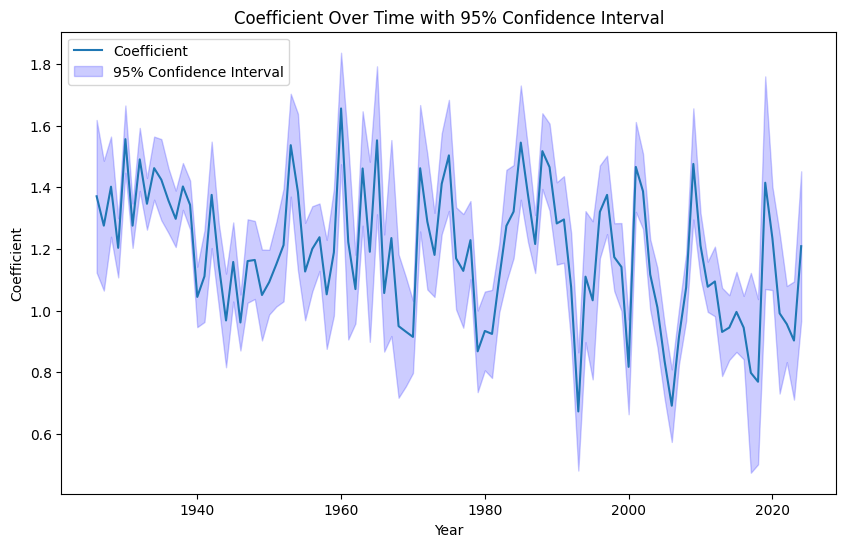

In [27]:
# lets plot the point estimates and the confidence intervals
y=1 # # you can change this to 5, 10, etc. to change the size of the sample
se=df_m.groupby((df_m.index.year // y) * y).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().bse['Mkt-RF'])
e=df_m.groupby((df_m.index.year // y) * y).apply(lambda x: sm.OLS(x['re'], sm.add_constant(x['Mkt-RF'])).fit().params['Mkt-RF'])
plt.figure(figsize=(10, 6))
plt.plot(e.index, e, label='Coefficient')
plt.fill_between(e.index, e - 1.96 * se, e + 1.96 * se, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Coefficient Over Time with 95% Confidence Interval')
plt.legend()
plt.show()



#### What question these standard errors/confidence intervals answer?

- They speak to the distribution of beta in sample--that is--
- Given the particular data, what is the distribution of beta consistent with it
- That is only relevant **if** these moments are constant
- Our estimation seems fairly confident of the beta on a particular year, but we need to know the beta NEXT year--or at the very least next month
- So lets look how past beta is associated with future beta

 🐍 Note : .shift(d) method
- Shift the variance series by d periods to create the lagged variable,
- i.e. if d=1 use the previous month's variance as a predictor for the current month's variance
- When you shift the series, the first row will be NaN because there is no previous month for the first month
- if you were to use -1 you would be using the next month's variance as a predictor for the current month's variance. would that make sense? No, because you would be using future information to predict the past

In [ ]:
plt.scatter(e.shift(1), e)
plt.plot(e.shift(1), e.shift(1),'-')
plt.xlabel('Lagged Coefficient')
plt.ylabel('Coefficient')
# There is a relationship
# But is the variation consistent with the standard errors?

#### It is a Forecasting Problem!

- How do we interpret these coefficients?
- What is your best guess of next year beta given this year beta?
- Is this good?
- A more humble approach--and what people typically do--is to use the last 2 years of data to predict next month beta--that does much better

In [ ]:
sm.OLS(e[1:], sm.add_constant(e.shift(1)[1:])).fit().summary()

### Exponential decay models

People in the industry also like exponential decay models

Instead of simply ignoring past observations, you instead put less weight on them

Instead of OLS you do GLS with weights given by

$$W_t=\frac{e^{-\delta(T-t)}}{\sum_t^T e^{-\delta(T-t)}}$$

In [ ]:
X = df_m['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_m['re']
n=y.shape[0]
decay_rate = 0.001 # Lambda controls the decay rate

df_m['weights']= y*0+np.exp(-decay_rate * np.arange(n)[::-1])  # Reverse order for recent weights
df_m['weights'] /= df_m['weights'].sum()  # Normalize weights to sum to 1 (optional)
plt.plot(df_m['weights'])
plt.title('Weights Over Time')

model = sm.WLS(y, X, weights=df_m['weights'])
results = model.fit()
display(results.summary())

## Variances

Variances come in two flavors. Factor variance and idiosyncratic variance.

Both tend to move together at high frequencies (days, weeks, a few months)

At horizons longer than 1 year, you are better off with low frequency estimates of variances--say use a two year-five year sample of daily returns

For investment horizons shorter than a month you certainly need to pay attention to higher frequency variation. So you might estimate using 3-month, 1-month , and even one day of data using minute-by-minute data

Lets start with the factor variance, that is the variance of the market

- For intuition I will  annualize it and look at standard deviation instead of variance


In [ ]:
(df_m['Mkt-RF'].var()*252)**0.5



### Variances Over time

- Average volatility  is 17% in a year--with a premium of 5% this means 16% of the time I will lose 12% of my money in 1 year, or get 22% return!
- Does it move around? Say is vol across years very similar?
- At the peak what is the 16% worst case investors have for their portfolio?

In [ ]:

(df_m['Mkt-RF'].rolling(window=252*1).std()*252**0.5).plot()


 ### 🐍 Note : Rolling method

 ```
 df_m['Mkt-RF'].rolling(window=freq).std()
 ```

 - The rolling method calculates a moving window statistic (e.g., mean, std) over a specified window size.
 Here, it computes the standard deviation of 'Mkt-RF' for the last 252 observations at each point in time.
 - This provides a time series of rolling standard deviations, which is then annualized and plotted.
 - Note that the windows overlap so rolling will naturally look persistent--so don't be deceived




### Nobel insight

Rob Engle won the nobel prize for developing models that forecast volatility.

![Robert F. Engle](https://www.stern.nyu.edu/faculty/static/photos/rengle.jpg?v=20250812154103)

Practicioners use very rich models ARCH, GARCH, Multi-frequency AR models, and also data from option markets--for example the VIX

Here I will do a simple regression based on the idea that volatility is persistence

We will estimate an AR(1) model

$$RV_{t+1}=a+bRV_t+\epsilon_{t+1}$$

- If vol persistent--surely looks like it--b>0 and past vol allow us to forecast future vol
- I will also use the VIX, which is the "market expectation" of the next 30 day volatility in the market




### Realized Variance


* Using daily data for month t, construct the market return "realized variance" during month t
   
   $$rv_t=\sum_{d \in days~ in ~month ~t}\frac{(r_d- \overline{r})^2}{N_{days}},$$
   
 where $\overline{r}$ is the average return within the month

 🐍 Note : Group the data by month-end dates

- pd.offsets.MonthEnd(0) ensures that the grouping aligns with the month-end of each date
- so all returns in the same month are grouped together
- So I can just compute the variance of this group (say 1/1/2020,1/2/2020,...1/31/2020) will all be associated with 1/31/2020

<Axes: >

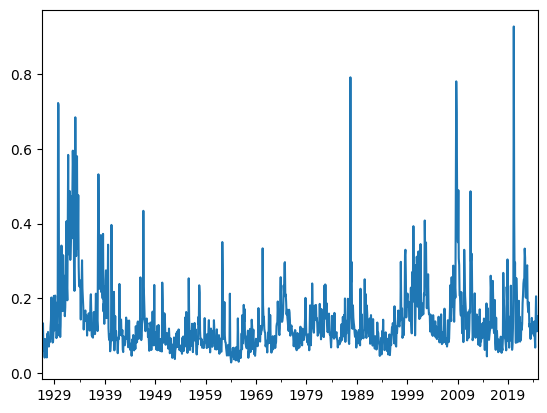

In [9]:
df_var=df_m.groupby(df_m.index+pd.offsets.MonthEnd(0)).apply(lambda x:x['Mkt-RF'].var()*252)
(df_var**0.5).plot()

# now there is no overlapping data points
# We see a lot of clustering--so volatility is persistent

### Forecasting Realized Variance

- you see we can forecast quite a bit of variation even with a only using the last month variance

In [10]:
import statsmodels.api as sm


# Shift the variance series by one period to create the lagged variable
df_var_lag = df_var.shift(1)
# Drop the first row with NaN value
# you have to drop in both series to align them correctly for regression
df_var = df_var[1:]
df_var_lag = df_var_lag[1:]
# Define the independent variable (lagged variance) and add a constant term
X = sm.add_constant(df_var_lag)
# Define the dependent variable (current variance)
y = df_var
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     483.3
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           4.84e-90
Time:                        18:49:20   Log-Likelihood:                 1878.5
No. Observations:                1181   AIC:                            -3753.
Df Residuals:                    1179   BIC:                            -3743.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.002      8.268      0.0

### Forecasting with market views

- Investors trade options on the SP500, which is 99% correlated with the total market portfolio
- One can prove that the payoff a certain portfolio  of these options is exactly the variance of the underlying, i.e. the SP500, for the maturity of the option
- So if you add up the option prices and weight them appropriately we have exactly the price of the portfolio that pays the variance
- the price of this portfolio is the VIX index (in fact it is the square-root of the price of the portfolio)

Suppose at month t, you expect variance next month be $(5\%)^2$

- You open your bloomberg and you see that  $VIX^2_t<(5\%)^2$, what should you do?
- And IF $VIX^2_t>(5\%)^2$, what should you do?
- What does this tell us?



/tmp/ipython-input-22081174.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix = vix.resample('M').last()  # Resample to monthly and take the last value


<Axes: xlabel='DATE'>

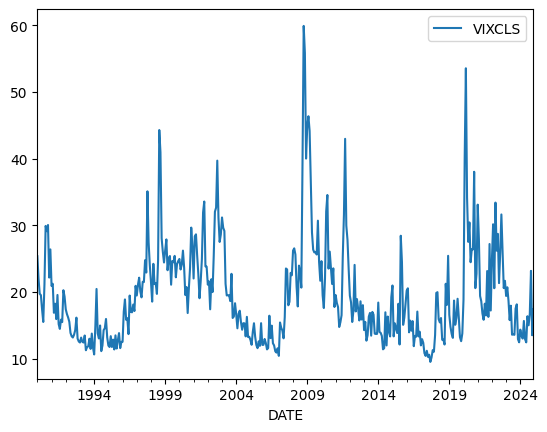

In [11]:

# Get VIX data from FRED
vix = DataReader.DataReader("VIXCLS", "fred", start=df_var.index.min(), end=df_var.index.max())
vix = vix.resample('M').last()  # Resample to monthly and take the last value
vix.plot()

In [12]:

# Merge VIX data with df_var
df_var_vix = df_var.to_frame(name='realized_variance').join((vix/100)**2, how='inner')

# Shift the variance series by one period to create the lagged variable
df_var_vix['VIX_lagged'] = df_var_vix['VIXCLS'].shift(1)
df_var_vix['realized_variance_lagged'] = df_var_vix['realized_variance'].shift(1)
# Drop the first row with NaN value
df_var_vix = df_var_vix.dropna()

# Define the independent variables (lagged variance and VIX) and add a constant term
X = sm.add_constant(df_var_vix[['realized_variance_lagged', 'VIX_lagged']])
# Define the dependent variable (current variance)
y = df_var_vix['realized_variance']
# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      realized_variance   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     127.6
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           6.25e-44
Time:                        18:49:34   Log-Likelihood:                 653.74
No. Observations:                 419   AIC:                            -1301.
Df Residuals:                     416   BIC:                            -1289.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Idiosyncratic  Volatility

Lets look now at the idiosyncratic component

Recall that


$$\epsilon=r^e-(\alpha+\beta*f)$$

and

$$Var(\epsilon)=Var(r^e-\beta*f)$$

So the variance of the idio component very much depends on your estimate of beta.

Here we will fix our beta estimate for the whole sample and then look at variation in the volatility of residuals the same we did for the variance of the market

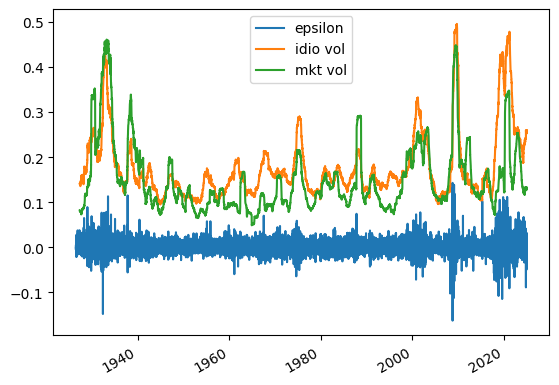

In [14]:
df_m=df_m.dropna()
X = df_m['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_m['re']
model = sm.OLS(y, X).fit(dropna=True)
df_m['e']=model.resid
df_m['e'].plot()

(df_m['e'].rolling(window=252).std()*252**0.5).plot()
(df_m['Mkt-RF'].rolling(window=252).std()*252**0.5).plot()
plt.legend(['epsilon','idio vol','mkt vol'])
# what do we learn?

### ⚡ ⏰ Question: G3 ⚡

- How do you do this using the Realized Variance (non-overlapping) approach?
- What models you would try to forecast indio vol? Be concrete!

## Cross-Section vs Time-series

- Variances tend to move up and down together
- you can repeat the forecasting exercise we did for the market variance to check out degree of  variation
- One thing that will be really important is to be able to detect variation in these moments (variance, beta) across stocks
- Here we are exploring the extent we can detect variation over time, but lots of trading strategies will be about comparing different stocks and be able to tell which one is more volatile going forward
- Predicting if a high beta stock is still high beta next month is easier, but harder to do
- For this we need to 💪-up our Pandas skills in order to work with many stocks at the same time





## Expected returns

Expected returns have three components


$$E[r]=rf+\alpha + b*E[f]$$

- the risk-free rate--> directly observed in financial markets
- The Factor risk-premia
- The alpha

### Factor Risk-Premia

- While conceptually both alpha and risk premia are both expected excess returns, in practice our approach is very different

- Factor risk-premia likely move around, but we think of then as a more stable features of the economic environment

- They are compensation for systematic risk, so they don't go away just because investors are aware of it

- We are more comfortable in using long data sets to measure it

  
We will now look at the risk-premia on the market and discuss how to think about the estimation, how to think about the precision of these estimates and briefly discuss how it might move around over time

**If We think a risk-premia does not move too much over time, then our best estimate is the sample average of the longest sample we can put our hands on**


$$\hat{E}[r^e]=\frac{1}{T}\sum_{t=1}^T r^e_t$$

* If observations are serially uncorrelated over time then the standard deviation of a sample average is simply


$$se(\hat{E}[r^e])=\sqrt{\frac{Var(r^e_t)}{T}}$$

* Returns of most *liquid* assets are sufficiently close to uncorrelated over time for this assumption to be ok
* It is also easy enough to adjust for serial correlation which we can  be done using a regression library.
* The longer the sample, the higher our precision, the lower the standard errors
* The higher the asset variance, the higher our standard errors, the lower our precision





In [17]:
# Daily is really ugly. Lets look at annual quantities
#The mean is multiplied by 252, because there are 252 days in a year
#Variance is also multiplied by 252, so standard-deviation gets multiplied by square root of it
#The number of observations are divided by 252 because now things are in years

# Calculate the average for the market
market_average = (df_m['Mkt-RF']*252).mean()
market_std_dev = (df_m['Mkt-RF']).std()*252**0.5
T=(len(df_m['Mkt-RF'])/252)
# Calculate the standard error of the average
market_average_std_error = market_std_dev / T** 0.5

print(f"Market standard deviation: {market_std_dev}")
# Calculate the standard error of the average


print(f"Market Average: {market_average}")
print(f"Standard Error of the Average: {market_average_std_error}")
print(f"t-stat relative to zero null: {(market_average-0)/market_average_std_error}")
# what do you notice about the t-stat?

Market standard deviation: 0.17101250291289558
Market Average: 0.07742251911344505
Standard Error of the Average: 0.016869220711097928
t-stat relative to zero null: 4.589572952976441



👉This makes the very important point that **sampling more frequently does not lead to more precise estimates of the expected return**

👉 "only time will tell" could not be any truer for means: Both mean and variance are scaled up by the frequency.


In [ ]:
nullh=0.03
t=(market_average-nullh)/market_average_std_error
print(f"t-stat relative to {nullh} null: {t}")
#what the interpretation of p?
p=1-norm.cdf(t)
print(p*100)

### Sample sizes and learning about means

- Suppose risk-premium is time-varying but moves  slowly
- Also lets suppose the variance is constant
- How long a sample do I need to be 95% confident that the expected value is higher than a given value, say 5%

I need


$$tstat>F^{-1}(0.95)=1.64$$


$$tstat=\frac{\hat{E}[r^e]-x}{se(\hat{E}[r^e])}>F^{-1}(0.95)=1.64$$


$$tstat=\frac{\hat{E}[r^e]-x}{\sqrt{\frac{Var(r^e_t)}{T}}}>F^{-1}(0.95)=1.64$$

manipulating

$$\sqrt{T}\frac{\hat{E}[r^e]-x}{\sigma(r^e_t)}=1.64$$

$$T=1.64^2*\left(\frac{\hat{E}[r^e]}{\sigma(r^e_t)}-\frac{x}{\sigma(r^e_t)}\right)^{-2}$$


- what is this term $\frac{\hat{E}[r^e]}{\sigma(r^e_t)}$ called?

- The more confident you want to be, the longer the sample you need
- The more volatile the asset the longer the sample
- The higher the expected value you have for the asset, the shorter the sample
- in the case of x=0 this becomes

$$T=1.64^2*\left(\frac{\hat{E}[r^e]}{\sigma(r^e_t)}\right)^{-2}$$

  
  Suppose we have an asset with similar moments as the market
  
  how long a sample do I expect to need to be confident that the asset has indeed positive mean?

In [18]:
quantile = 0.95
value_at_quantile = norm.ppf(quantile)
sr=market_average/market_std_dev
(sr)**(-2)*value_at_quantile**2


np.float64(13.200052067961026)

⚡ ⏰ Question: G4 ⚡

1. What does it tell you about opening a hedge fund? This about the investors and their problem

2. What this tell you about pod shops looking for very high SR strategies? How this makes high SR strategies extra desirable?





### Detecting time-variation in means

Lets look at the market splitting it in 15 year periods

- even then there would be multiple 15 year periods where we would not be 95% sure that the market has a positive expected return

- If you think the market risk-premium moves much faster than this, then the sample mean is fairly unreliable estimator

- This insight will be very important to think about alphas. Why?

- This also tells you that timing the market based on past performance--even 15 past performance is a disaster!

In [ ]:
y=15
a=df.groupby((df.index.year // y) * y).apply(lambda x: x['Mkt-RF'].mean()/(x['Mkt-RF'].std()/x['Mkt-RF'].count()**0.5))
plt.axhline(y=1.64, color='r', linestyle='--', label='1.64 Threshold')
plt.legend()
a.plot()


Huge literature tries to forecast market return

- They use past volatility (bad, does not work at all)
- Dividend yield (maybe, a bit unreliable)
- earnings yield (similar for dividend yield)
- "Variance-Risk Premium", basically the VIX minus past vol--that works a bit better, but sample is short, so hard to be sure


In the end of the day it comes down to

$$r_{t+1}=a+bX_t+\epsilon_{t+1}$$

where anything that is known at date $t$ is a valid trading signal (past vol,...)

It is very tricky business

We will look at this in our timing lecture

## Alpha is all you need

In one way estimating an alpha is similar to estimating factor risk-premia

- Both are expected values of the excess returns
- Alpha is the expected value of the hedged portfolio

$$\alpha=E[r^e-\beta f]$$

- So you might think the longer the sample, the better right?
- But while for factor premia we have lots of theory telling us that it should move very slowly
   * it is about aggregate risk--and it should not go away just because people know it
   * people might choose not to go all in because it is risky!
- For alphas, it is the opposite, everyone is jumping when alpha is detected. The whole point is that alpha, real alpha, are premiums that you earn after you HEDGE out any aggregate factor exposure your portfolio have
- What happens with the price as more people buy an asset?
- What happens with the asset actual long-term value?
- What happens with the alpha?


So lets first get a few stocks and compare their alphas.

- I will estimate for each stock their alpha in a 1-year sample and compare with the alpha the following 1 year
- But you should free to be creative here. You could use 1 year to predict a month and so on
- The goal here is to show one way of doing things--but there are many other similar ways

/tmp/ipython-input-1066857734.py:38: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Research_Data_Factors_daily", "famafrench",start="1921-01-01")


                MSFT      AAPL      CSCO      ORCL     GOOGL
2004-08-20  0.002900  0.002881 -0.011568 -0.010607  0.079434
2004-08-23  0.004362  0.009041  0.015840 -0.001020  0.010014
2004-08-24 -0.000050  0.027942 -0.010999  0.002863 -0.041458
2004-08-25  0.011330  0.034379  0.018400  0.006726  0.010725
2004-08-26 -0.004043  0.048664 -0.007814 -0.016396  0.017969


<Axes: >

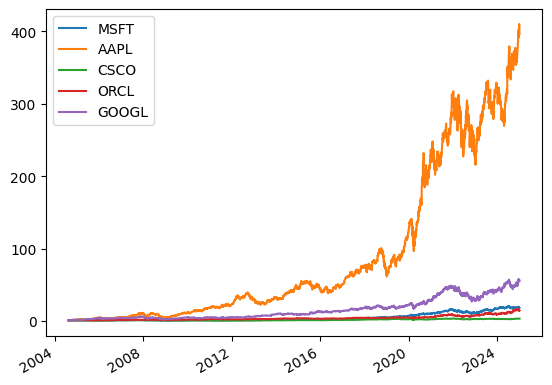

In [19]:
## uncomment to use WRDS to get data
# conn = wrds.Connection()
# tickers=['MSFT','AAPL','CSCO','ORCL','GOOGL']
# df= get_daily_wrds(conn,tickers).dropna()
# df.to_csv('../../assets/data/FactorModelsEstimation_data2.csv')
#######################################

df=pd.read_csv('https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/FactorModelsEstimation_data2.csv')
df.date=pd.to_datetime(df.date)
df.set_index('date',inplace=True)

df_factor = get_factors()
df, df_factor = df.align(df_factor, join='inner', axis=0)

df_re=df.subtract(df_factor['RF'],axis=0)

print(df_re.head())
(1+df_re).cumprod().plot()



In [22]:


# Define the period length
period_length = 1

# Create a dictionary to store the results
results_dict = {'Ticker': [], 'Period': [], 'Alpha': [], 'Alpha_SE': [], 'Alpha_Tstat': []}

# Loop through each 5-year period
for _ in range(df_re.index.year._(), df_re.index.year._(), _):
    end_year = start_year + period_length - 1
    period_label = end_year

    # What these three lines are doing?
    period_mask = (df_re.index.year >= start_year) & (df_re.index.year <= end_year)
    df_re_period = df_re[period_mask]
    df_factor_period = df_factor[period_mask]

    # Loop through each column in df_re
    for __ in __:
        try:
            y = df_re_period[ticker]
            X = sm.add_constant(df_factor_period['Mkt-RF'])
            model = sm.OLS(y, X, missing='drop').fit()
            # Store the results
            results_dict['Ticker'].append(ticker)
            results_dict['Period'].append(period_label)
            results_dict['Alpha'].append(model.params['const']*252)
            results_dict['Alpha_SE'].append(model.bse['const']*252)
            results_dict['Alpha_Tstat'].append(model.params['const']/model.bse['const'])
        except:
            pass

# Convert the results dictionary to a DataFrame

results_df = pd.DataFrame(results_dict)

# Display the results
print(results_df)

   Ticker  Period     Alpha  Alpha_SE  Alpha_Tstat
0    MSFT    2004 -0.024998  0.173270    -0.144270
1    AAPL    2004  1.813820  0.695292     2.608718
2    CSCO    2004 -0.453783  0.381393    -1.189802
3    ORCL    2004  0.337930  0.490314     0.689211
4   GOOGL    2004  1.875742  0.880526     2.130251
..    ...     ...       ...       ...          ...
95   MSFT    2023  0.231046  0.205052     1.126763
96   AAPL    2023  0.167875  0.146782     1.143703
97   CSCO    2023 -0.080818  0.180123    -0.448682
98   ORCL    2023  0.075019  0.273346     0.274449
99  GOOGL    2023  0.202679  0.248743     0.814816

[100 rows x 5 columns]


 ### 🐍 Note : Stacked data sets
- Note that we know need two coordinates to identify one observation: Ticker and Period
- To visualize this we want to plot the alpha of company A in year Y against the same company alpha in year Y+1
- Can we simply use the shift operator like this?

```
plt.plot(results_df.shift(1)['Alpha'],results_df.Alpha , 'o')
```
⚡ ⏰ Question: G4 ⚡

- if yes, why it works?

- If not, how do we fix it?

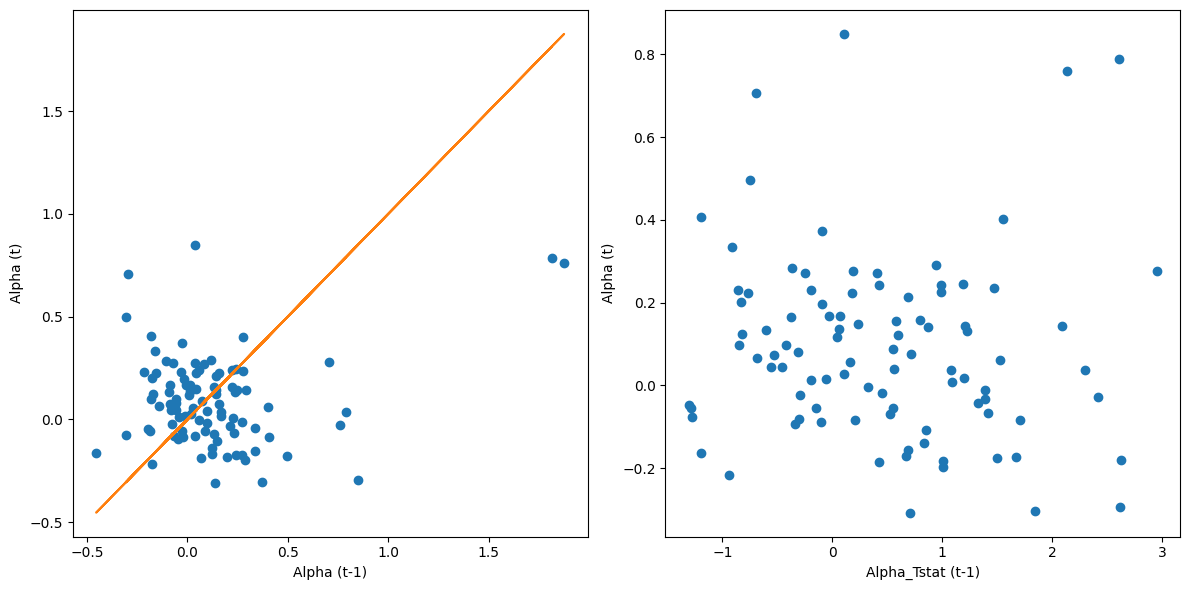

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Alpha(t-1) vs Alpha(t)
axes[0].plot(results_df.__.shift(1)['Alpha'], results_df['Alpha'], 'o')
axes[0].plot(results_df['Alpha'], results_df['Alpha'], '-')
axes[0].set_xlabel('Alpha (t-1)')
axes[0].set_ylabel('Alpha (t)')

# Plot Alpha_Tstat(t-1) vs Alpha(t)
axes[1].plot(results_df.__.shift(1)['Alpha_Tstat'], results_df['Alpha'], 'o')
axes[1].set_xlabel('Alpha_Tstat (t-1)')
axes[1].set_ylabel('Alpha (t)')


plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels



- You see that no matter the horizon there is no PREDICTIVE relationship, last period alpha is not related to future period alpha
- You see that even if you sort on t-stat, it is not better
- Even quite high T-stats are not associated with higher future alphas
- This is not surprising!
- Alpha is all you want and all you need. So everyone is chasing it
- So you expect that alpha of an asset or a trading strategy should be very transient-- it will quickly disappears as people learn about it
- This will pose a challenge for you



###  How do you find alpha?

- Estimating Alpha is hard!
- Every one in the business is searching for alpha
- So true alpha is
  - hard to find
  - disappears quickly
  - if the data was clear, people would already jumped at it
  - Once too much capital is in the trade we say that the trade is "crowded"
  - A crowded trade can yield NEGATIVE alpha, even if the original idea was right!
  - You have to be right, but also early.
  - If the trade gets crowded after you already in, is that good or bad? What do you do?
  - Can you be too early?

### If not estimation then what?

You need to think!


- Valuation. You understand a business/market and think the market is not seeing what you are seeing. IT can be short-term insight, like a big client will cancel their services, or long-term prospects for the company business.
  - Warren Buffet whole stick is about this. Read his letters to shareholders. It is all about finding good firms at good value
  - David Einhorn is another example. He famously betted against Leahman Brothers.
  - Often this view will be formed by not only looking at balance sheets , but interacting with company insiders. Even though interactions are public, access allow a good fundamental analyst to see things more clearly (if you get private information, it is of course "easier" but it is illegal and you might end up in jail!)
  - Edge here is having good business judgment. You need to be confident that you are seeing something different form the market and you are right!
  - IT is good discipline to think why people are thinking the wrong thing--you need to understand why the opportunity is there in the first place
  






  
- Liquidity provision
  - When firms are downgraded some fund are forced to sell, this often creates reversals
  - Similar effect happens when a firm is dropped from an index, say SP500
  - And it happens in the opposite direction when it is added to the index
  - When mutual fund suffers outflows, they often have to sell, this often creates reversals are as well
  - The bet here is that you understand the reason these buy and sells are happening--and that they are not about fundamental news
  - So you bet the price movements triggered by them will ultimate revert, so you take the other side of the trade--i.e. provide liquidity (at a sweet premium of course)
  








  
- Data that other people don't have.
  - Famous example are satellite pictures of parking lots of retail stores--might allow you to predict sales better which hopefully translates into predictions about prices once the market becomes aware of the sales
  - Flow data--this is slightly different from liquidity provision--as you can front run buys/sells if you know that the flows are coming and that they will move markets
  - flooding data, exposure to temperature,
  - supplier data
  - See below a diagram by JP Morgan illustrating the variety of data sources


![Alternative Data](https://github.com/amoreira2/Fin418/blob/main/assets/plots/alternativedata.png?raw=1)


### Alpha Quantification Procedure

- Regardless how you get to you alpha, in the end you have to put your trading insights in the same playing field
- Need to choose an horizon, say a month, and put all your alpha in that frequency.

Example:

- Say you have a theory that NVDIA currently trading at 1000 will be at 800 in one year due to things that entirely specific to NVDIA (that is a -20% return)
- Suppose you do not have a theory of when exactly that will happen
- Then you alpha for next month is $(0.8)^{(1/12)}-1\approx-1.8\%$
- Now suppose you know the timing--so you know this  bad news is likely to come only on the last two earnings of the year, then you alpha=0 for the first six months of the year and $(0.8)^{(1/6)}-1\approx-3.6\%$ for last six months of the year




  

### Real Alpha is unique and cannot be driven by broad macro factors

- It is useful to develop views for a range of firms/ industries to check that you are not implicitly making a market-wide bet
- if that is your bet, it is silly to hedge market risk--and it is very inefficient  to buy a single stock to trade this view
- You should just buy the market in this case!
- And it is important to be aware because it is much harder to be right!
- In practice the notion of "broad macro factors" is much broader then market beta and will often include exposure to a variety of factors, including industry factors
- While it is ok to make a bet on an industry, it is important to know exactly what your trade is
- Buying NVDIA because your bullish on the tech sector is not efficient--you should buy the whole tech sector in that case--much less risk per unit of exposure- as it is not exposed to NVDIA specific factors?

## 📝 Key Takeaways

-  Betas, variances, and even risk-premia can be estimated with historical data, although we varying look-back windows

- Standard errors can be deceiving   

- Alphas are different

- Converting a one-year price target into a monthly alpha ensures consistent sizing and portfolio aggregation.  

- Understand where your edge comes from


---


## Extra Material: The Normal distribution

* Most of what we do does not depend on the assumption of normality

* But normal distributions are very useful in statistical tests

* And they are also not a bad approximation for return data at low frequency (monthly/year)

* Probability that any random draw form a Normal distribution random variable $\tilde{x}$ is within $n=1$ standard deviation from the mean is 0.6826


$$Prob(E[\tilde{x}]-1\sigma(\tilde{x})\leq \tilde{x}\leq E[\tilde{x}]+1\sigma(\tilde{x}))=0.6826$$

* $n=2,Prob(\cdot)=0.9550$

$$Prob(E[\tilde{x}]-2\sigma(\tilde{x})\leq \tilde{x}\leq E[\tilde{x}]+2\sigma(\tilde{x}))=0.9550$$
* it is convenient to to transform a normally distributed r.v. into units of standard deviations from it's mean


$$\tilde{z}=\frac{\tilde{x}-E[\tilde{x}]}{\sigma(\tilde{x})}$$

* This follows the "standard" normal distribution, which has mean 0 and and standard deviation 1

* can you show that is indeed the case that z has mean zero and standard devaiton 1?

* This means that the normal distribution is completely characterized by it's first two moments

* This means that the investment problem is much more tractable too!

* Only two moments to worry about:

    * The expected return of the portfolio
    
    * it's variance
    
    * The probability of really bad tail events will follow immediately from these two!

In [ ]:
from scipy.stats import norm

#quantile function
x=norm.ppf(0.95)
print(norm.ppf(0.95))
# cdf
norm.cdf(x)